# Nutri-score predictive model for food and beverages

### Libraries

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

### Reading the nutriscore's file

In [50]:
df = pd.read_csv('/Users/dansandler/Proyecto_final_ironhack/final project/filtered_file.csv', sep=',', encoding='utf-8')
df

,nutriscore,product,country,primary_category,secondary_category,ecoscore,energy_kcal_100g,fat_100g,saturated_fat_100g,unsaturated_fat_100g,...,trans_fat_100g,cholesterol_100g,carbs_100g,sugars_100g,fiber_100g,protein_100g,salt_100g,sodium_100g,fruits_veg_nuts_estimate_100g,expected_min_calories
0,a,Skyr,France,Milk and dairy products,Dairy desserts,b,57.0,0.2,0.1,0.0,...,0.0,0.0,3.9,3.9,0.0,10.0,0.09,0.036,0.0,55.45
1,d,Pur jus de pomme,France,Beverages,Fruit juices,c,63.0,0.0,0.0,0.0,...,0.0,0.0,15.5,15.5,0.0,0.2,0.00,0.000,0.0,55.05
2,a,Salade de carottes râpées,France,Composite foods,One-dish meals,b,32.0,0.3,0.1,0.0,...,0.0,0.0,5.3,3.9,0.0,0.9,0.42,0.168,0.0,24.85
3,d,Tarte noix de coco,France,Composite foods,Pizza pies and quiches,unknown,381.0,22.0,15.5,0.0,...,0.0,0.0,27.3,21.9,4.4,4.6,0.10,0.040,0.0,311.95
4,a,Compote de poire,France,Fruits and vegetables,Fruits,b,157.0,0.0,0.0,0.0,...,0.0,0.0,36.0,27.0,3.6,0.6,0.00,0.000,0.0,128.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723657,c,Yaourt vanille,France,Milk and dairy products,Milk and yogurt,b,128.0,7.6,5.1,0.0,...,0.0,0.0,12.0,11.0,0.0,2.7,0.09,0.036,0.0,121.20
723658,c,Riz au lait,France,Milk and dairy products,Dairy desserts,c,150.0,6.1,4.3,0.0,...,0.0,0.0,21.0,14.0,0.0,2.9,0.08,0.032,0.0,140.00
723659,b,Riz parfumé,France,Cereals and potatoes,Cereals,e,351.0,0.5,0.0,0.0,...,0.0,0.0,80.0,0.0,0.0,7.0,0.00,0.000,0.0,312.50
723660,a,Skimmed Milk,United Kingdom,Milk and dairy products,Milk and yogurt,unknown,35.0,0.1,0.1,0.0,...,0.0,0.0,5.0,5.0,0.0,3.6,0.12,0.048,0.0,32.80


In [51]:
df.shape

(723662, 22)

In [52]:
df['nutriscore'].value_counts()

nutriscore
d    215411
c    149533
e    141831
a    120066
b     96821
Name: count, dtype: int64

In [53]:
df.columns

Index(['nutriscore', 'product', 'country', 'primary_category',
       'secondary_category', 'ecoscore', 'energy_kcal_100g', 'fat_100g',
       'saturated_fat_100g', 'unsaturated_fat_100g',
       'mono_unsaturated_fat_100g', 'poly_unsaturated_fat_100g',
       'trans_fat_100g', 'cholesterol_100g', 'carbs_100g', 'sugars_100g',
       'fiber_100g', 'protein_100g', 'salt_100g', 'sodium_100g',
       'fruits_veg_nuts_estimate_100g', 'expected_min_calories'],
      dtype='object')

In [54]:
df['primary_category'].unique()

array(['Milk and dairy products', 'Beverages', 'Composite foods',
       'Fruits and vegetables', 'Fish Meat Eggs', 'Cereals and potatoes',
       'Sugary snacks', 'Salty snacks', 'Fat and sauces'], dtype=object)

## Separate the Beverages from the rest of the categories in order to have one model for food products and another one for beverages products.

In [55]:
df_without_beverage = df[df['primary_category'] != 'Beverages']

In [56]:
df_beverage = df[df['primary_category'] == 'Beverages']

# Correlation and heatmaps

#### Mapping Nutri-Score to numerical values

In [57]:
nutriscore_mapping = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5}
df_without_beverage['nutriscore_numeric'] = df_without_beverage['nutriscore'].map(nutriscore_mapping)

/var/folders/p_/v0r6zns15kvc6kdp98q2n1b00000gn/T/ipykernel_25122/2807973376.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_beverage['nutriscore_numeric'] = df_without_beverage['nutriscore'].map(nutriscore_mapping)


#### Selecting numeric features

In [58]:
numeric_features = df_without_beverage[['energy_kcal_100g', 'fat_100g', 'saturated_fat_100g',
                       'unsaturated_fat_100g', 'mono_unsaturated_fat_100g',
                       'poly_unsaturated_fat_100g', 'trans_fat_100g',
                       'cholesterol_100g', 'carbs_100g', 'sugars_100g',
                       'fiber_100g', 'protein_100g', 'salt_100g',
                       'sodium_100g', 'fruits_veg_nuts_estimate_100g']]

#### Adding the numeric Nutri-Score to the numeric features

In [59]:
numeric_features['nutriscore'] = df_without_beverage['nutriscore_numeric']

/var/folders/p_/v0r6zns15kvc6kdp98q2n1b00000gn/T/ipykernel_25122/2113139230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_features['nutriscore'] = df_without_beverage['nutriscore_numeric']


#### Calculating the correlation matrix

In [60]:
correlation_matrix = numeric_features.corr()

In [61]:
correlation_matrix

,energy_kcal_100g,fat_100g,saturated_fat_100g,unsaturated_fat_100g,mono_unsaturated_fat_100g,poly_unsaturated_fat_100g,trans_fat_100g,cholesterol_100g,carbs_100g,sugars_100g,fiber_100g,protein_100g,salt_100g,sodium_100g,fruits_veg_nuts_estimate_100g,nutriscore
energy_kcal_100g,1.000000,0.778553,0.577224,0.010217,0.171277,0.137833,0.022162,0.002522,0.435531,0.294905,0.163456,0.135430,-0.043918,-0.043918,-0.176415,0.545396
fat_100g,0.778553,1.000000,0.712727,0.014325,0.228905,0.171103,0.020578,0.005124,-0.168287,-0.052110,-0.001794,0.129378,0.060470,0.060466,-0.061903,0.476475
saturated_fat_100g,0.577224,0.712727,1.000000,0.003982,0.055906,0.030478,0.023335,0.008972,-0.097342,0.077539,-0.055764,0.153683,0.019193,0.019192,-0.165983,0.566806
unsaturated_fat_100g,0.010217,0.014325,0.003982,1.000000,0.008129,0.014443,-0.000276,-0.000087,-0.003181,-0.002639,0.003097,-0.001040,-0.002520,-0.002520,0.002691,-0.000098
mono_unsaturated_fat_100g,0.171277,0.228905,0.055906,0.008129,1.000000,0.554692,0.010299,0.006992,-0.029775,-0.033982,0.007183,-0.043619,-0.019413,-0.019413,0.052717,0.020330
poly_unsaturated_fat_100g,0.137833,0.171103,0.030478,0.014443,0.554692,1.000000,0.012310,0.000423,-0.006462,-0.030148,0.032622,-0.033608,0.002377,0.002376,0.017666,0.031543
trans_fat_100g,0.022162,0.020578,0.023335,-0.000276,0.010299,0.012310,1.000000,0.013079,0.010349,0.012310,-0.004851,-0.003776,0.001949,0.001950,-0.012380,0.034398
cholesterol_100g,0.002522,0.005124,0.008972,-0.000087,0.006992,0.000423,0.013079,1.000000,-0.004897,-0.001650,-0.004451,0.005392,0.003606,0.003606,-0.005150,0.006885
carbs_100g,0.435531,-0.168287,-0.097342,-0.003181,-0.029775,-0.006462,0.010349,-0.004897,1.000000,0.647705,0.217292,-0.240355,-0.244185,-0.244182,-0.145527,0.202516
sugars_100g,0.294905,-0.052110,0.077539,-0.002639,-0.033982,-0.030148,0.012310,-0.001650,0.647705,1.000000,-0.020560,-0.351011,-0.290415,-0.290415,-0.029308,0.428877


#### Heatmap

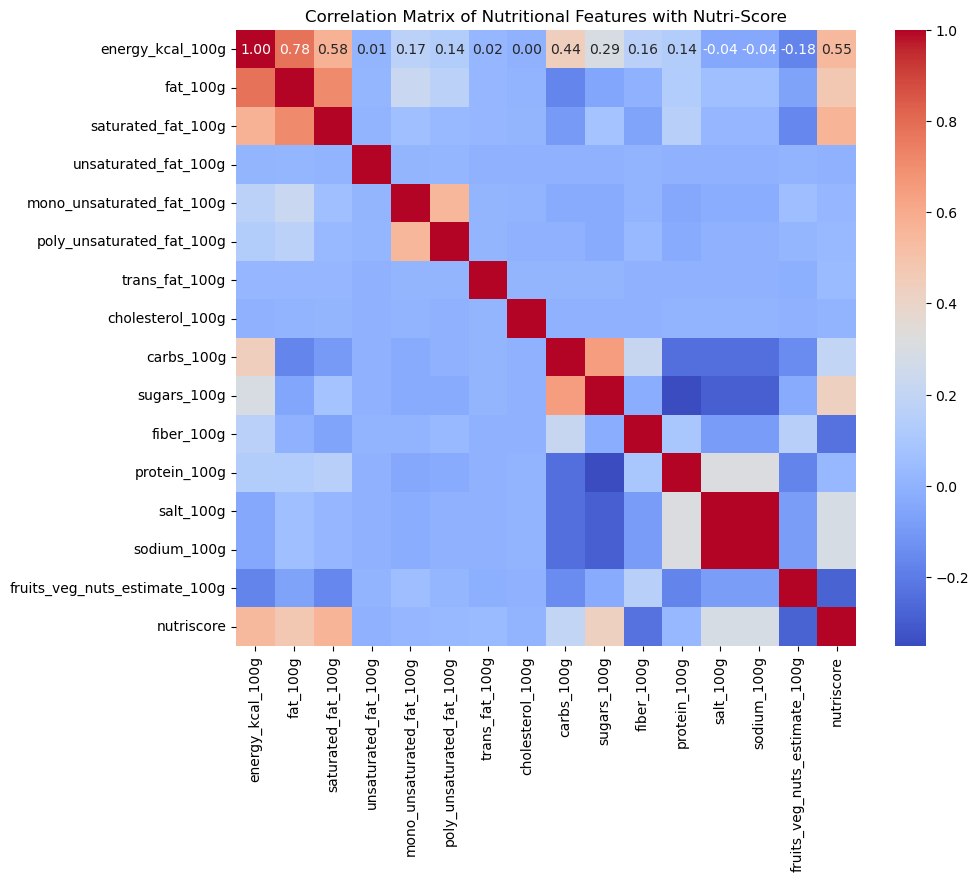

In [62]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Nutritional Features with Nutri-Score')
plt.show()

# Predictive models

## Food

### Selecting numeric features

In [63]:
numeric_features = df_without_beverage[['energy_kcal_100g', 'fat_100g', 'saturated_fat_100g', 
                    'carbs_100g', 'sugars_100g', 'fiber_100g', 
                    'protein_100g', 'salt_100g', 'fruits_veg_nuts_estimate_100g']]

### KNN model

In [64]:
X= numeric_features
y = df_without_beverage["nutriscore"]

#### Convert categorical target variable to numerical values

In [65]:
label_encoder = LabelEncoder()
y_encoder = label_encoder.fit(y)
y_encoded = y_encoder.transform(y)

#### Splitting the data into training and test sets

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)

#### Normalizing the data

In [67]:
minmax = MinMaxScaler()
scaler = minmax.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

#### Initialize the model


In [68]:
knn = KNeighborsClassifier(n_neighbors=3)

#### Train the model

In [69]:
knn.fit(X_train_norm, y_train)

KNeighborsClassifier(n_neighbors=3)

#### Predicting on the test set

In [70]:
y_pred_knn = knn.predict(X_test_norm)

In [71]:
X_train

,energy_kcal_100g,fat_100g,saturated_fat_100g,carbs_100g,sugars_100g,fiber_100g,protein_100g,salt_100g,fruits_veg_nuts_estimate_100g
442694,240.0,8.4,4.6,30.0,1.9,1.9,10.0,0.90,0.000000
351170,463.0,20.0,6.4,64.0,40.0,0.0,6.1,0.88,0.000000
629770,187.0,9.0,8.2,25.0,24.0,0.0,1.7,0.13,0.000000
675590,537.0,31.6,3.1,55.0,1.0,0.0,7.3,0.20,0.000000
477179,97.0,0.2,0.1,20.4,20.1,0.0,1.7,2.30,0.000000
...,...,...,...,...,...,...,...,...,...
389181,162.0,6.2,4.3,24.0,21.0,0.0,2.7,0.16,0.000000
167601,160.0,0.0,0.0,30.0,10.0,30.0,10.0,9.80,79.166667
129920,258.0,21.1,10.5,0.5,0.5,0.0,16.5,2.60,0.000000
471967,606.0,48.0,10.0,20.0,5.0,5.0,21.0,1.90,0.000000


#### Evaluate KNN

In [72]:
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_))
print("KNN Accuracy Score:", accuracy_score(y_test, y_pred_knn))

KNN Classification Report:
              precision    recall  f1-score   support

           a       0.91      0.93      0.92     23582
           b       0.81      0.81      0.81     17897
           c       0.87      0.85      0.86     27580
           d       0.93      0.93      0.93     41016
           e       0.95      0.94      0.95     23650

    accuracy                           0.90    133725
   macro avg       0.89      0.89      0.89    133725
weighted avg       0.90      0.90      0.90    133725

KNN Accuracy Score: 0.9006692839783137


### Random Forest Classifier

In [73]:
rf = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')
rf.fit(X_train_norm, y_train)
y_pred_rf = rf.predict(X_test_norm)

#### Evaluate Random Forest

In [74]:
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
print("Random Forest Accuracy Score:", accuracy_score(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           a       0.96      0.96      0.96     23582
           b       0.93      0.91      0.92     17897
           c       0.94      0.94      0.94     27580
           d       0.96      0.97      0.97     41016
           e       0.98      0.96      0.97     23650

    accuracy                           0.95    133725
   macro avg       0.95      0.95      0.95    133725
weighted avg       0.95      0.95      0.95    133725

Random Forest Accuracy Score: 0.9549149373714713


#### Random Forest Feature Importance:

In [75]:
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)


                         Feature  Importance
7                      salt_100g    0.190451
2             saturated_fat_100g    0.179523
4                    sugars_100g    0.132889
0               energy_kcal_100g    0.108722
1                       fat_100g    0.101904
5                     fiber_100g    0.094030
6                   protein_100g    0.084320
3                     carbs_100g    0.062038
8  fruits_veg_nuts_estimate_100g    0.046122


In [2]:
#!pip install wordcloud


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 1.7 MB/s eta 0:00:00a 0:00:01


/var/folders/p_/v0r6zns15kvc6kdp98q2n1b00000gn/T/ipykernel_31113/1854204983.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(word_freq))  # Use 'tab20' colormap for distinct colors


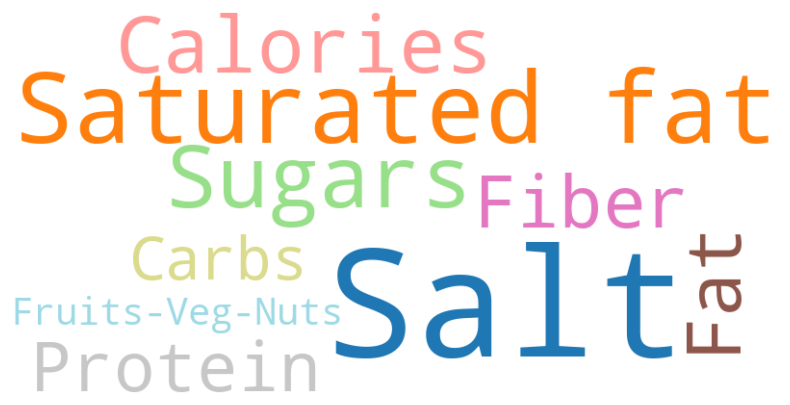

In [4]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_hex
import matplotlib.cm as cm

# Create a DataFrame with the feature and their importance
data = {
    'Feature': [
        'Salt', 
        'Saturated fat', 
        'Sugars', 
        'Calories', 
        'Fat', 
        'Fiber', 
        'Protein', 
        'Carbs', 
        'Fruits-Veg-Nuts'
    ],
    'Importance': [
        0.190451, 
        0.179523, 
        0.132889, 
        0.108722, 
        0.101904, 
        0.094030, 
        0.084320, 
        0.062038, 
        0.046122
    ]
}

df = pd.DataFrame(data)

# Create a dictionary for WordCloud
word_freq = dict(zip(df['Feature'], df['Importance']))

# Define a custom color function
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Use a colormap to get a color for each word based on its importance
    cmap = cm.get_cmap('tab20', len(word_freq))  # Use 'tab20' colormap for distinct colors
    norm = plt.Normalize(vmin=0, vmax=len(word_freq))
    color = cmap(norm(list(word_freq.values()).index(word_freq[word])))  # Map importance to color
    return to_hex(color)

# Create the WordCloud object with the custom color function
wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate_from_frequencies(word_freq)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [76]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X_train_norm, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())


KeyboardInterrupt: 

## Reading the unknown dataframe

In [77]:
df_unknown = pd.read_csv('/Users/dansandler/Proyecto_final_ironhack/final project/unknown_score_file.csv', sep=',', encoding='utf-8')
df_unknown

,nutriscore,product,country,primary_category,secondary_category,ecoscore,energy_kcal_100g,fat_100g,saturated_fat_100g,unsaturated_fat_100g,...,trans_fat_100g,cholesterol_100g,carbs_100g,sugars_100g,fiber_100g,protein_100g,salt_100g,sodium_100g,fruits_veg_nuts_estimate_100g,expected_min_calories
0,unknown,Danoises à la cannelle roulées,Canada,Sugary snacks,Biscuits and cakes,unknown,363.0,14.40,0.00,0.0,...,0.0,0.0411,54.10,28.10,2.05,4.79,0.922,0.369,0.000,338.110
1,unknown,Jus de Pomme,France,Beverages,Fruit juices,c,42.0,0.00,0.00,0.0,...,0.0,0.0000,9.95,9.67,0.00,0.00,0.000,0.000,0.000,34.825
2,unknown,Pommes cannelle séchées,Belgium,Fruits and vegetables,Dried fruits,unknown,292.0,0.50,0.10,0.0,...,0.0,0.0000,65.00,51.00,0.00,2.00,0.000,0.000,9.375,240.000
3,unknown,Born fruta fresca deshidratada,Spain,Fruits and vegetables,Dried fruits,unknown,362.1,10.30,9.00,0.0,...,0.0,0.0000,60.90,56.50,9.50,5.00,0.000,0.000,0.000,325.850
4,unknown,Salam de vară,United States,Fish Meat Eggs,Processed meat,e,336.0,29.00,13.00,0.0,...,0.0,0.0000,0.60,0.30,8.00,18.00,0.000,0.000,0.000,335.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52043,unknown,Sablés natures,France,Sugary snacks,Biscuits and cakes,c,468.0,16.00,1.40,0.0,...,0.0,0.0000,79.00,20.00,1.60,1.10,0.000,0.000,0.000,424.900
52044,unknown,fuze tea pesca e rosa,Italy,Beverages,Teas and herbal teas and coffees,c,33.0,0.00,0.00,0.0,...,0.0,0.0000,8.00,8.00,0.00,0.00,0.000,0.000,0.000,28.000
52045,unknown,Nectar d'abricot,France,Beverages,Fruit nectars,c,59.0,0.00,0.00,0.0,...,0.0,0.0000,14.00,12.00,0.00,0.40,0.000,0.000,0.000,50.600
52046,unknown,cup noodles,France,Cereals and potatoes,Cereals,c,84.0,3.80,2.00,0.0,...,0.0,0.0000,10.20,0.50,0.00,1.80,1.000,0.400,0.000,77.100


### Separating the food from the entire 'unknown' dataframe.

In [78]:
df_unknown_food = df_unknown[df_unknown['primary_category'] != 'Beverages']

In [79]:
df_unknown_food

,nutriscore,product,country,primary_category,secondary_category,ecoscore,energy_kcal_100g,fat_100g,saturated_fat_100g,unsaturated_fat_100g,...,trans_fat_100g,cholesterol_100g,carbs_100g,sugars_100g,fiber_100g,protein_100g,salt_100g,sodium_100g,fruits_veg_nuts_estimate_100g,expected_min_calories
0,unknown,Danoises à la cannelle roulées,Canada,Sugary snacks,Biscuits and cakes,unknown,363.0,14.40,0.00,0.0,...,0.0,0.0411,54.10,28.10,2.05,4.79,0.922,0.369,0.000,338.11
2,unknown,Pommes cannelle séchées,Belgium,Fruits and vegetables,Dried fruits,unknown,292.0,0.50,0.10,0.0,...,0.0,0.0000,65.00,51.00,0.00,2.00,0.000,0.000,9.375,240.00
3,unknown,Born fruta fresca deshidratada,Spain,Fruits and vegetables,Dried fruits,unknown,362.1,10.30,9.00,0.0,...,0.0,0.0000,60.90,56.50,9.50,5.00,0.000,0.000,0.000,325.85
4,unknown,Salam de vară,United States,Fish Meat Eggs,Processed meat,e,336.0,29.00,13.00,0.0,...,0.0,0.0000,0.60,0.30,8.00,18.00,0.000,0.000,0.000,335.10
5,unknown,"Celebrations, candy",United States,Sugary snacks,Sweets,unknown,497.0,24.91,14.65,0.0,...,0.0,0.0000,61.54,54.58,0.00,5.49,0.000,0.000,0.000,461.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52041,unknown,Confiture fraises bio,France,Sugary snacks,Sweets,b,167.0,0.00,0.00,0.0,...,0.0,0.0000,42.00,42.00,0.00,0.50,0.000,0.000,0.000,149.00
52042,unknown,La Panna Cotta,France,Milk and dairy products,Dairy desserts,b,179.0,14.00,8.70,0.0,...,0.0,0.0000,12.00,11.00,0.00,2.50,0.000,0.000,0.000,178.00
52043,unknown,Sablés natures,France,Sugary snacks,Biscuits and cakes,c,468.0,16.00,1.40,0.0,...,0.0,0.0000,79.00,20.00,1.60,1.10,0.000,0.000,0.000,424.90
52046,unknown,cup noodles,France,Cereals and potatoes,Cereals,c,84.0,3.80,2.00,0.0,...,0.0,0.0000,10.20,0.50,0.00,1.80,1.000,0.400,0.000,77.10


### Implementing the food nutriscore model to the food products.

In [80]:
X_unknown_food = df_unknown_food[['energy_kcal_100g', 'fat_100g', 'saturated_fat_100g', 'carbs_100g', 
                                  'sugars_100g', 'fiber_100g', 'protein_100g', 'salt_100g', 
                                  'fruits_veg_nuts_estimate_100g']]
X_unknown_food_scaled = scaler.transform(X_unknown_food)

In [81]:
y_pred_unknown_food = rf.predict(X_unknown_food_scaled)
df_unknown_food['nutriscore'] = y_pred_unknown_food

/var/folders/p_/v0r6zns15kvc6kdp98q2n1b00000gn/T/ipykernel_25122/4271424487.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unknown_food['nutriscore'] = y_pred_unknown_food


In [83]:
df_unknown_food.reset_index()

,index,nutriscore,product,country,primary_category,secondary_category,ecoscore,energy_kcal_100g,fat_100g,saturated_fat_100g,...,trans_fat_100g,cholesterol_100g,carbs_100g,sugars_100g,fiber_100g,protein_100g,salt_100g,sodium_100g,fruits_veg_nuts_estimate_100g,expected_min_calories
0,0,d,Danoises à la cannelle roulées,Canada,Sugary snacks,Biscuits and cakes,unknown,363.0,14.40,0.00,...,0.0,0.0411,54.10,28.10,2.05,4.79,0.922,0.369,0.000,338.11
1,2,d,Pommes cannelle séchées,Belgium,Fruits and vegetables,Dried fruits,unknown,292.0,0.50,0.10,...,0.0,0.0000,65.00,51.00,0.00,2.00,0.000,0.000,9.375,240.00
2,3,d,Born fruta fresca deshidratada,Spain,Fruits and vegetables,Dried fruits,unknown,362.1,10.30,9.00,...,0.0,0.0000,60.90,56.50,9.50,5.00,0.000,0.000,0.000,325.85
3,4,c,Salam de vară,United States,Fish Meat Eggs,Processed meat,e,336.0,29.00,13.00,...,0.0,0.0000,0.60,0.30,8.00,18.00,0.000,0.000,0.000,335.10
4,5,e,"Celebrations, candy",United States,Sugary snacks,Sweets,unknown,497.0,24.91,14.65,...,0.0,0.0000,61.54,54.58,0.00,5.49,0.000,0.000,0.000,461.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42958,52041,c,Confiture fraises bio,France,Sugary snacks,Sweets,b,167.0,0.00,0.00,...,0.0,0.0000,42.00,42.00,0.00,0.50,0.000,0.000,0.000,149.00
42959,52042,d,La Panna Cotta,France,Milk and dairy products,Dairy desserts,b,179.0,14.00,8.70,...,0.0,0.0000,12.00,11.00,0.00,2.50,0.000,0.000,0.000,178.00
42960,52043,c,Sablés natures,France,Sugary snacks,Biscuits and cakes,c,468.0,16.00,1.40,...,0.0,0.0000,79.00,20.00,1.60,1.10,0.000,0.000,0.000,424.90
42961,52046,c,cup noodles,France,Cereals and potatoes,Cereals,c,84.0,3.80,2.00,...,0.0,0.0000,10.20,0.50,0.00,1.80,1.000,0.400,0.000,77.10


### Add a boolean column indicating that the nutriscore was predicted or not for food DataFrames

In [84]:
df_unknown_food['predicted'] = True
df_without_beverage['predicted'] = False

/var/folders/p_/v0r6zns15kvc6kdp98q2n1b00000gn/T/ipykernel_25122/1649897072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unknown_food['predicted'] = True
/var/folders/p_/v0r6zns15kvc6kdp98q2n1b00000gn/T/ipykernel_25122/1649897072.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_beverage['predicted'] = False


### Concatenating the Food DataFrame with Known Nutriscore and the Food DataFrame with Predicted Nutriscore

In [85]:
df_food_after_pred = pd.concat([df_without_beverage, df_unknown_food,], ignore_index=True)

### Extracting the file as csv file.

In [86]:
df_food_after_pred.to_csv('/Users/dansandler/Proyecto_final_ironhack/final project/df_food_after_pred.csv', index=False)